<ipython-input-1-60679b5bb9a4>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  input_batch = torch.Tensor(input_batch)


Epoch: 1000 cost = 2.080632
Epoch: 2000 cost = 1.605930
Epoch: 3000 cost = 1.502186
Epoch: 4000 cost = 1.499131
Epoch: 5000 cost = 1.075388


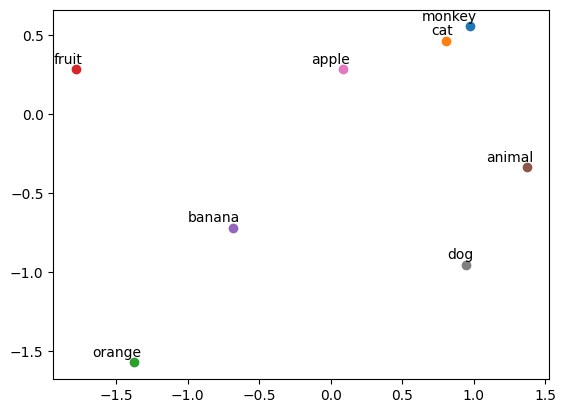

In [1]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

if __name__ == '__main__':
    batch_size = 2 # mini-batch size
    embedding_size = 2 # embedding size

    sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
                 "dog cat animal", "cat monkey animal", "monkey dog animal"]

    word_sequence = " ".join(sentences).split()
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    voc_size = len(word_list)

    # Make skip gram of one size window
    skip_grams = []
    for i in range(1, len(word_sequence) - 1):
        target = word_dict[word_sequence[i]]
        context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
        for w in context:
            skip_grams.append([target, w])

    model = Word2Vec()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(5000):
        input_batch, target_batch = random_batch()
        input_batch = torch.Tensor(input_batch)
        target_batch = torch.LongTensor(target_batch)

        optimizer.zero_grad()
        output = model(input_batch)

        # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    for i, label in enumerate(word_list):
        W, WT = model.parameters()
        x, y = W[0][i].item(), W[1][i].item()
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()


# install FastText

In [2]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

--2025-03-22 19:02:47--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0 [following]
--2025-03-22 19:02:47--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.116.10
Connecting to codeload.github.com (codeload.github.com)|140.82.116.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [  <=>               ]   4.10M  17.7MB/s    in 0.2s    

2025-03-22 19:02:48 (17.7 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  infla

# making sample dataset

In [3]:
# 1 is positive, 0 is negative
f = open('train.txt', 'w')
f.write('__label__1 i love you\n')
f.write('__label__1 he loves me\n')
f.write('__label__1 she likes baseball\n')
f.write('__label__0 i hate you\n')
f.write('__label__0 sorry for that\n')
f.write('__label__0 this is awful')
f.close()

f = open('test.txt', 'w')
f.write('sorry hate you')
f.close()

# Training

In [4]:
!./fasttext supervised -input train.txt -output model -dim 2

Read 0M words
Number of words:  17
Number of labels: 2
Progress: 100.0% words/sec/thread:   16728 lr:  0.000000 loss:  0.666566 ETA:   0h 0m


# predict

In [5]:
!cat test.txt
!./fasttext predict model.bin test.txt

sorry hate you__label__0


In [7]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def make_batch():
    input_batch, target_batch = [], []

    for seq in seq_data:
        input = [word_dict[n] for n in seq[:-1]] # 'm', 'a' , 'k' is input
        target = word_dict[seq[-1]] # 'e' is target
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Linear(n_hidden, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, X):
        input = X.transpose(0, 1)  # X : [n_step, batch_size, n_class]

        hidden_state = torch.zeros(1, len(X), n_hidden)  # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        cell_state = torch.zeros(1, len(X), n_hidden)     # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]

        outputs, (_, _) = self.lstm(input, (hidden_state, cell_state))
        outputs = outputs[-1]  # [batch_size, n_hidden]
        model = self.W(outputs) + self.b  # model : [batch_size, n_class]
        return model

if __name__ == '__main__':
    n_step = 3 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']
    word_dict = {n: i for i, n in enumerate(char_arr)}
    number_dict = {i: w for i, w in enumerate(char_arr)}
    n_class = len(word_dict)  # number of class(=number of vocab)

    seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star']

    model = TextLSTM()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    input_batch, target_batch = make_batch()
    input_batch = torch.FloatTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    # Training
    for epoch in range(1000):
        optimizer.zero_grad()

        output = model(input_batch)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 100 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    inputs = [sen[:3] for sen in seq_data]

    predict = model(input_batch).data.max(1, keepdim=True)[1]
    print(inputs, '->', [number_dict[n.item()] for n in predict.squeeze()])

Epoch: 0100 cost = 0.495523
Epoch: 0200 cost = 0.031427
Epoch: 0300 cost = 0.009823
Epoch: 0400 cost = 0.004748
Epoch: 0500 cost = 0.002815
Epoch: 0600 cost = 0.001872
Epoch: 0700 cost = 0.001340
Epoch: 0800 cost = 0.001007
Epoch: 0900 cost = 0.000785
Epoch: 1000 cost = 0.000629
['mak', 'nee', 'coa', 'wor', 'lov', 'hat', 'liv', 'hom', 'has', 'sta'] -> ['e', 'd', 'l', 'd', 'e', 'e', 'e', 'e', 'h', 'r']


In [6]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def make_batch():
    input_batch = []
    target_batch = []

    words = sentence.split()
    for i, word in enumerate(words[:-1]):
        input = [word_dict[n] for n in words[:(i + 1)]]
        input = input + [0] * (max_len - len(input))
        target = word_dict[words[i + 1]]
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, bidirectional=True)
        self.W = nn.Linear(n_hidden * 2, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, X):
        input = X.transpose(0, 1)  # input : [n_step, batch_size, n_class]

        hidden_state = torch.zeros(1*2, len(X), n_hidden)   # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden)     # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        outputs, (_, _) = self.lstm(input, (hidden_state, cell_state))
        outputs = outputs[-1]  # [batch_size, n_hidden]
        model = self.W(outputs) + self.b  # model : [batch_size, n_class]
        return model

if __name__ == '__main__':
    n_hidden = 5 # number of hidden units in one cell

    sentence = (
        'Lorem ipsum dolor sit amet consectetur adipisicing elit '
        'sed do eiusmod tempor incididunt ut labore et dolore magna '
        'aliqua Ut enim ad minim veniam quis nostrud exercitation'
    )

    word_dict = {w: i for i, w in enumerate(list(set(sentence.split())))}
    number_dict = {i: w for i, w in enumerate(list(set(sentence.split())))}
    n_class = len(word_dict)
    max_len = len(sentence.split())

    model = BiLSTM()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    input_batch, target_batch = make_batch()
    input_batch = torch.FloatTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    # Training
    for epoch in range(10000):
        optimizer.zero_grad()
        output = model(input_batch)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    predict = model(input_batch).data.max(1, keepdim=True)[1]
    print(sentence)
    print([number_dict[n.item()] for n in predict.squeeze()])


Epoch: 1000 cost = 1.953202
Epoch: 2000 cost = 1.316637
Epoch: 3000 cost = 1.061701
Epoch: 4000 cost = 0.891879
Epoch: 5000 cost = 0.671005
Epoch: 6000 cost = 0.524165
Epoch: 7000 cost = 0.448496
Epoch: 8000 cost = 0.407791
Epoch: 9000 cost = 0.357419
Epoch: 10000 cost = 0.310618
Lorem ipsum dolor sit amet consectetur adipisicing elit sed do eiusmod tempor incididunt ut labore et dolore magna aliqua Ut enim ad minim veniam quis nostrud exercitation
['ipsum', 'dolor', 'amet', 'amet', 'consectetur', 'adipisicing', 'elit', 'sed', 'do', 'tempor', 'tempor', 'incididunt', 'et', 'labore', 'et', 'magna', 'magna', 'aliqua', 'Ut', 'enim', 'ad', 'minim', 'veniam', 'quis', 'nostrud', 'exercitation']


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
<ipython-input-8-77b3f64f3178>:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


Epoch: 0400 cost = 0.000472
Epoch: 0800 cost = 0.000151
Epoch: 1200 cost = 0.000074
Epoch: 1600 cost = 0.000043
Epoch: 2000 cost = 0.000028
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


<ipython-input-8-77b3f64f3178>:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
<ipython-input-8-77b3f64f3178>:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


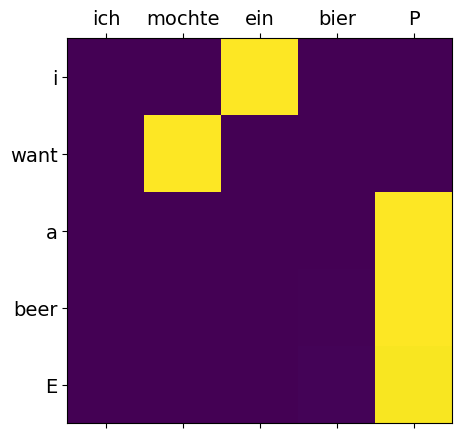

In [8]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()

    # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

Epoch: 1000 cost = 0.004461
Epoch: 2000 cost = 0.001106
Epoch: 3000 cost = 0.000453
Epoch: 4000 cost = 0.000217
Epoch: 5000 cost = 0.000113
sorry hate you is Bad Mean...


<ipython-input-9-169a4a541533>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
<ipython-input-9-169a4a541533>:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})


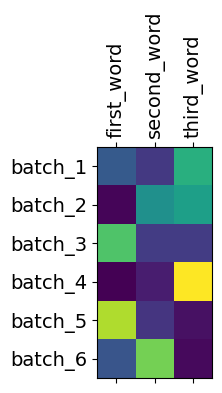

In [9]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

if __name__ == '__main__':
    embedding_dim = 2 # embedding size
    n_hidden = 5  # number of hidden units in one cell
    num_classes = 2  # 0 or 1

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    model = BiLSTM_Attention()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
    targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function

    # Training
    for epoch in range(5000):
        optimizer.zero_grad()
        output, attention = model(inputs)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    predict, _ = model(test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()

Epoch: 0001 cost = 2.220344
Epoch: 0002 cost = 1.680743
Epoch: 0003 cost = 4.935616
Epoch: 0004 cost = 3.401870
Epoch: 0005 cost = 4.974960
Epoch: 0006 cost = 2.549376
Epoch: 0007 cost = 2.086322
Epoch: 0008 cost = 2.774581
Epoch: 0009 cost = 1.589631
Epoch: 0010 cost = 1.375642
Epoch: 0011 cost = 1.208881
Epoch: 0012 cost = 0.967248
Epoch: 0013 cost = 0.742610
Epoch: 0014 cost = 0.564641
Epoch: 0015 cost = 0.403828
Epoch: 0016 cost = 0.320570
Epoch: 0017 cost = 0.294198
Epoch: 0018 cost = 0.254597
Epoch: 0019 cost = 1.621585
Epoch: 0020 cost = 0.624454
ich mochte ein bier P -> ['i', 'E', 'E', 'E', 'E']
first head of last state enc_self_attns


<ipython-input-10-02a81116f23f>:173: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-10-02a81116f23f>:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


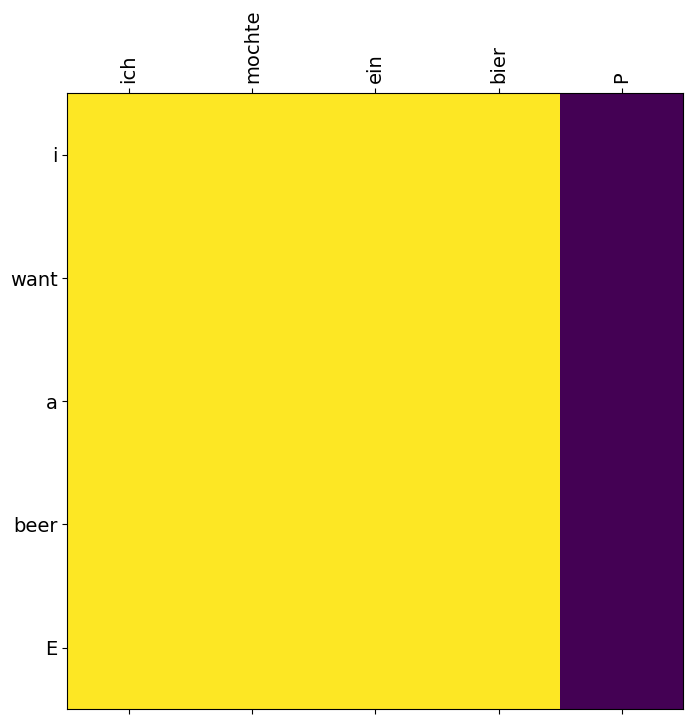

first head of last state dec_self_attns


<ipython-input-10-02a81116f23f>:173: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-10-02a81116f23f>:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


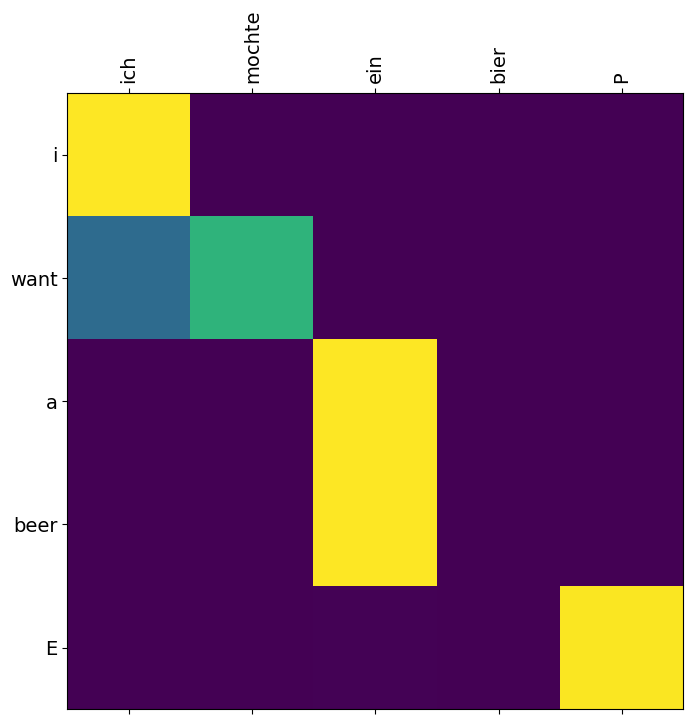

<ipython-input-10-02a81116f23f>:173: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-10-02a81116f23f>:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


first head of last state dec_enc_attns


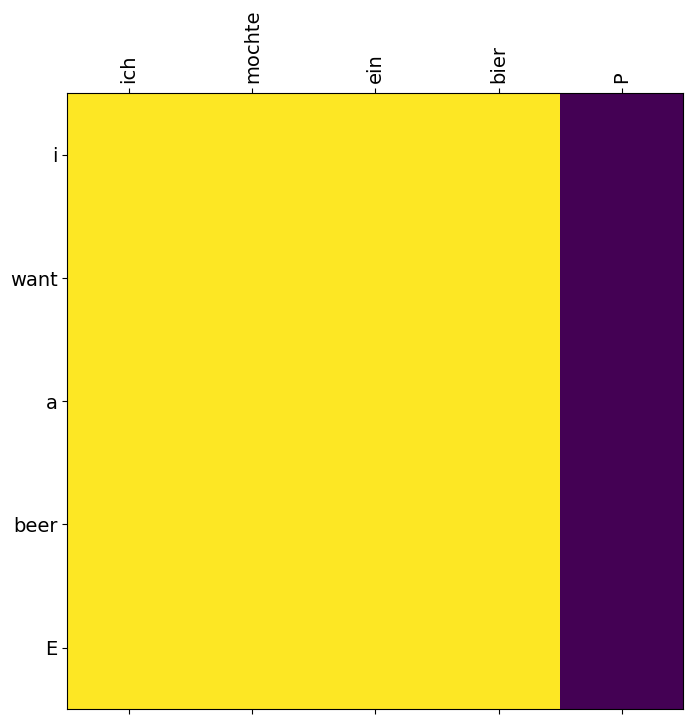

In [10]:
# code by Tae Hwan Jung(Jeff Jung) @graykode, Derek Miller @dmmiller612
# Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
#           https://github.com/JayParks/transformer
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

if __name__ == '__main__':
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    # Transformer Parameters
    # Padding Should be Zero
    src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
    src_vocab_size = len(src_vocab)

    tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
    number_dict = {i: w for i, w in enumerate(tgt_vocab)}
    tgt_vocab_size = len(tgt_vocab)

    src_len = 5 # length of source
    tgt_len = 5 # length of target

    d_model = 512  # Embedding Size
    d_ff = 2048  # FeedForward dimension
    d_k = d_v = 64  # dimension of K(=Q), V
    n_layers = 6  # number of Encoder of Decoder Layer
    n_heads = 8  # number of heads in Multi-Head Attention

    model = Transformer()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    enc_inputs, dec_inputs, target_batch = make_batch(sentences)

    for epoch in range(20):
        optimizer.zero_grad()
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, target_batch.contiguous().view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

    # Test
    predict, _, _, _ = model(enc_inputs, dec_inputs)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    print('first head of last state enc_self_attns')
    showgraph(enc_self_attns)

    print('first head of last state dec_self_attns')
    showgraph(dec_self_attns)

    print('first head of last state dec_enc_attns')
    showgraph(dec_enc_attns)

In [11]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
#           https://github.com/JayParks/transformer, https://github.com/dhlee347/pytorchic-bert
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# sample IsNext and NotNext to be same in small batch size
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences)) # sample random index in sentences
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]
        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        # MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
    return batch
# Proprecessing Finished

def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def gelu(x):
    "Implementation of the gelu activation function by Hugging Face"
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(gelu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf

if __name__ == '__main__':
    # BERT Parameters
    maxlen = 30 # maximum of length
    batch_size = 6
    max_pred = 5  # max tokens of prediction
    n_layers = 6 # number of Encoder of Encoder Layer
    n_heads = 12 # number of heads in Multi-Head Attention
    d_model = 768 # Embedding Size
    d_ff = 768 * 4  # 4*d_model, FeedForward dimension
    d_k = d_v = 64  # dimension of K(=Q), V
    n_segments = 2

    text = (
        'Hello, how are you? I am Romeo.\n'
        'Hello, Romeo My name is Juliet. Nice to meet you.\n'
        'Nice meet you too. How are you today?\n'
        'Great. My baseball team won the competition.\n'
        'Oh Congratulations, Juliet\n'
        'Thanks you Romeo'
    )
    sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'
    word_list = list(set(" ".join(sentences).split()))
    word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
    for i, w in enumerate(word_list):
        word_dict[w] = i + 4
    number_dict = {i: w for i, w in enumerate(word_dict)}
    vocab_size = len(word_dict)

    token_list = list()
    for sentence in sentences:
        arr = [word_dict[s] for s in sentence.split()]
        token_list.append(arr)

    model = BERT()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    batch = make_batch()
    input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

    for epoch in range(100):
        optimizer.zero_grad()
        logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
        loss = loss_lm + loss_clsf
        if (epoch + 1) % 10 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

    # Predict mask tokens ans isNext
    input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))
    print(text)
    print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])

    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
    logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
    print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
    print('predict masked tokens list : ',[pos for pos in logits_lm if pos != 0])

    logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]
    print('isNext : ', True if isNext else False)
    print('predict isNext : ',True if logits_clsf else False)


Epoch: 0010 cost = 50.600647
Epoch: 0020 cost = 35.503395
Epoch: 0030 cost = 36.456039
Epoch: 0040 cost = 11.348446
Epoch: 0050 cost = 6.505054
Epoch: 0060 cost = 5.244511
Epoch: 0070 cost = 5.227342
Epoch: 0080 cost = 3.234647
Epoch: 0090 cost = 3.694013
Epoch: 0100 cost = 3.954060
Hello, how are you? I am Romeo.
Hello, Romeo My name is Juliet. Nice to meet you.
Nice meet you too. How are you today?
Great. My baseball team won the competition.
Oh Congratulations, Juliet
Thanks you Romeo
['[CLS]', 'nice', '[MASK]', 'you', 'too', 'how', '[MASK]', 'you', 'today', '[SEP]', 'thanks', 'you', 'romeo', '[SEP]']
masked tokens list :  [28, 7]
predict masked tokens list :  [np.int64(28), np.int64(28)]
isNext :  False
predict isNext :  False


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
